In [1]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pypfopt
from pypfopt import risk_models, expected_returns, Plotting
import pandas as pd
import numpy as np
from pandas_datareader import data, wb
import datetime
import scipy.optimize as sco
from scipy import stats
import matplotlib.pyplot as plt

from configs import COMPANIES_LIST, start_date, end_date
from utils import smartDataReader,get_last_raw,deal_with_add_constraints
pd.set_option("display.max_columns", 101)
pypfopt.__version__

'1.2.1'

In [3]:
import os
os.getcwd()

'C:\\PycharmProjects\\finance\\portfolio_diversification'

In [2]:
df = smartDataReader(name=COMPANIES_LIST, data_source='yahoo', start=start_date, end=end_date, force_reload=False,retry_count=30)
tickers = df['Adj Close'].columns[~df['Adj Close'][:3].isna().any()]
df = df['Adj Close'][tickers].dropna()
df.head(1)
past_df, future_df = df.iloc[:-250], df.iloc[-250:]


yahoo_20191020000000_AALAAPLAMDAMZNBABABPCCLCOLMDALDISFBGPSGRALUVMSFTNFLXNVDARCLRDSBRYAAYSAVETOT_30_20050101000000
9e5d41ab02e29919282f8378b0ffaa5f9809c579c969a7632de0b2335eca1831
Loading data from disk


In [46]:
past_df.shape

(3475, 15)

In [47]:
# df.iloc[:]

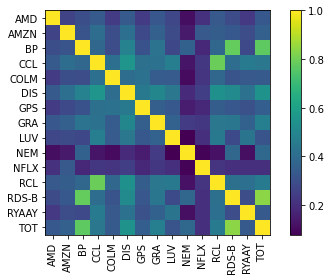

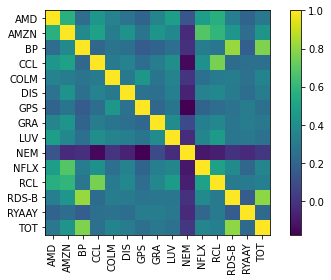

In [48]:
future_cov = risk_models.sample_cov(future_df)

sample_cov = risk_models.sample_cov(past_df)
Plotting.plot_covariance(sample_cov)
Plotting.plot_covariance(future_cov)
plt.show()

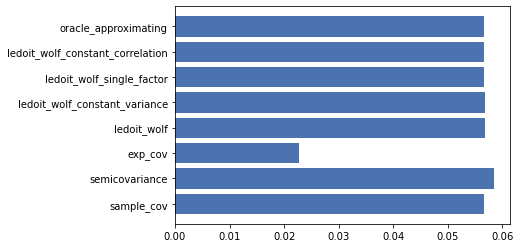

In [49]:
future_variance = np.diag(future_cov)

mean_abs_errors = []

risk_methods = [
    "sample_cov",
    "semicovariance",
    "exp_cov",
    "ledoit_wolf",
    "ledoit_wolf_constant_variance",
    "ledoit_wolf_single_factor",
    "ledoit_wolf_constant_correlation",
    "oracle_approximating",
]

for method in risk_methods:
    S = risk_models.risk_matrix(df, method=method)
    variance = np.diag(S)
    mean_abs_errors.append(np.sum(np.abs(variance - future_variance)) / len(variance))
    
xrange = range(len(mean_abs_errors))
plt.barh(xrange, mean_abs_errors)
plt.yticks(xrange, risk_methods)
plt.show()

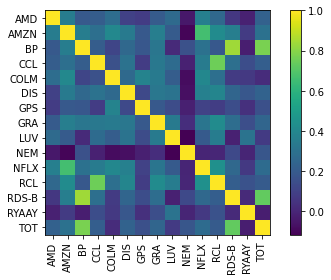

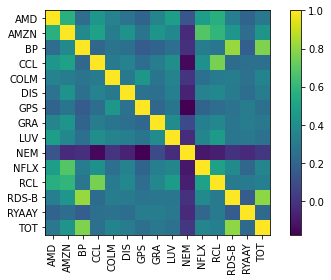

In [50]:
exp_cov = risk_models.exp_cov(past_df)
Plotting.plot_covariance(exp_cov)
Plotting.plot_covariance(future_cov)
plt.show()

### Returns

In [52]:
future_rets = expected_returns.mean_historical_return(future_df)
mean_abs_errors = []
return_methods = [
    "mean_historical_return",
    "ema_historical_return",
    "james_stein_shrinkage",
    "capm_return",
    ]

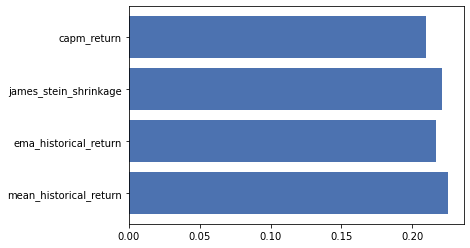

In [53]:
for method in return_methods:
    mu = expected_returns.return_model(past_df, method=method)
    mean_abs_errors.append(np.sum(np.abs(mu - future_rets)) / len(mu))
    
xrange = range(len(mean_abs_errors))
plt.barh(xrange, mean_abs_errors)
plt.yticks(xrange, return_methods)
plt.show()

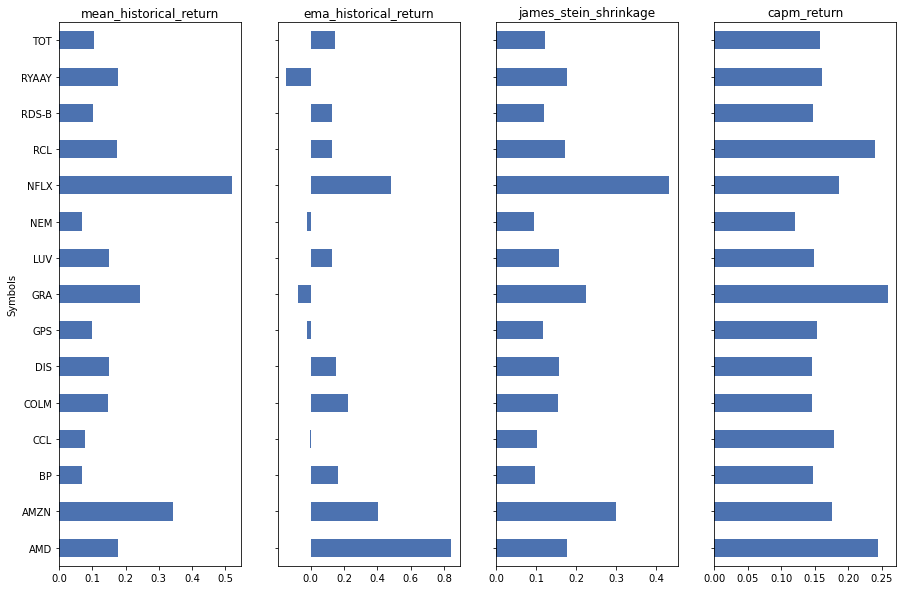

In [54]:

fig, axs = plt.subplots( 1, len(return_methods),sharey=True, figsize=(15,10))

for i, method in enumerate(return_methods):
    mu = expected_returns.return_model(past_df, method=method)
    axs[i].set_title(method)
    mu.plot.barh(ax=axs[i])